# Random Forest - Hyperparameter Tuning & Training (Selected Features)

1. Define Random Forest model.
2. Define hyperparameter search space.
3. Use RandomizedSearchCV with Stratified K-Fold Cross-Validation on the resampled training data (selected features).
4. Find the best hyperparameters based on Average Precision score.
5. Evaluate the best model on the validation set.
6. Perform final evaluation on the test set.
7. Save the best model.

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
from scipy.stats import randint

## 1. Load Data
Load the datasets: resampled training set, scaled validation set, scaled test set.

In [5]:
try:
    X_train = pd.read_csv('../../data/processed/no_transformed/X_train_no_transform_selected.csv') # Contains selected features
    y_train = pd.read_csv('../../data/processed/no_transformed/y_train_no_transform_scaled_resampled.csv')
    X_val = pd.read_csv('../../data/processed/no_transformed/X_val_no_transform_selected.csv') # Contains selected features
    y_val = pd.read_csv('../../data/processed/no_transformed/y_val_no_transform.csv')
    X_test = pd.read_csv('../../data/processed/no_transformed/X_test_no_transform_selected.csv') # Contains selected features
    y_test = pd.read_csv('../../data/processed/no_transformed/y_test_no_transform.csv')
    print("Data loaded successfully.")
    print("X_train shape:", X_train.shape)
    print("X_validate shape:", X_val.shape)
    print("X_test shape:", X_test.shape)
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the data files are present in the correct paths.")
    # Exit or handle error appropriately
    exit() # Simple exit for script-like execution in notebook

Data loaded successfully.
X_train shape: (4762, 10)
X_validate shape: (984, 10)
X_test shape: (984, 10)


## 2. Define Model and Hyperparameter Space

In [6]:
# Define the base model
rf = RandomForestClassifier(random_state=42, class_weight=None, n_jobs=-1) # class_weight=None as y_train is resampled

In [7]:
# Define the parameter distribution for Randomized Search
param_distributions = {
    'n_estimators': randint(100, 601),       # Number of trees (e.g., 100 to 600)
    'max_depth': [10, 20, 30, 40, None],      # Max depth of trees
    'min_samples_split': randint(2, 11),    # Min samples to split node (e.g., 2 to 10)
    'min_samples_leaf': randint(1, 5),      # Min samples per leaf node (e.g., 1 to 4)
    'max_features': ['sqrt', 'log2', 0.5, None] # Number of features to consider for split
    # 'criterion': ['gini', 'entropy']      # Split criterion
}

## 3. Setup Cross-Validation and Randomized Search

In [8]:
# Stratified K-Fold for cross-validation within the training set
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# Randomized Search setup
# n_iter = number of parameter settings sampled. Increase for better search, decrease for speed.
# scoring = 'average_precision' is good for imbalanced problems (even if training data is balanced, validation/test are not)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,        # Adjust number of iterations
    cv=cv_strategy,
    scoring='average_precision',
    n_jobs=-1,        # Use all cores
    random_state=42,
    verbose=1         # Show progress
)

## 4. Run Hyperparameter Search

In [10]:
print("Starting Randomized Search CV for Random Forest (All Features)...")
# Fit on the resampled training data
random_search.fit(X_train, y_train.values.ravel())
print("Search complete.")

Starting Randomized Search CV for Random Forest (All Features)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.


## 5. Analyze Search Results

In [11]:
print(f"Best Parameters found: {random_search.best_params_}")
print(f"Best Average Precision (CV score): {random_search.best_score_:.4f}")

# Get the best model found by the search
best_rf_selected_features = random_search.best_estimator_

Best Parameters found: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 539}
Best Average Precision (CV score): 0.9929


## 6. Evaluate on Validation Set

In [12]:
print("\n--- Evaluating Best Model on Validation Set (All Features) ---")
y_pred_val = best_rf_selected_features.predict(X_val)
y_pred_proba_val = best_rf_selected_features.predict_proba(X_val)[:, 1]

print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val))
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)
pr_auc_val = average_precision_score(y_val, y_pred_proba_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")
print(f"Validation Precision-Recall AUC Score: {pr_auc_val:.4f}")


--- Evaluating Best Model on Validation Set (All Features) ---
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       794
           1       0.77      0.92      0.84       190

    accuracy                           0.93       984
   macro avg       0.88      0.93      0.90       984
weighted avg       0.94      0.93      0.93       984

Validation ROC AUC Score: 0.9820
Validation Precision-Recall AUC Score: 0.9264


## 7. Final Evaluation on Test Set

In [13]:
print("\n--- Evaluating Best Model on Test Set (Selected Features) ---")
y_pred_test = best_rf_selected_features.predict(X_test)
y_pred_proba_test = best_rf_selected_features.predict_proba(X_test)[:, 1]

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
pr_auc_test = average_precision_score(y_test, y_pred_proba_test)
print(f"Test ROC AUC Score: {roc_auc_test:.4f}")
print(f"Test Precision-Recall AUC Score: {pr_auc_test:.4f}")


--- Evaluating Best Model on Test Set (All Features) ---
Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       794
           1       0.79      0.89      0.84       190

    accuracy                           0.93       984
   macro avg       0.88      0.92      0.90       984
weighted avg       0.94      0.93      0.93       984

Test ROC AUC Score: 0.9762
Test Precision-Recall AUC Score: 0.9054


## 8. Plot Metrics (Test Set)

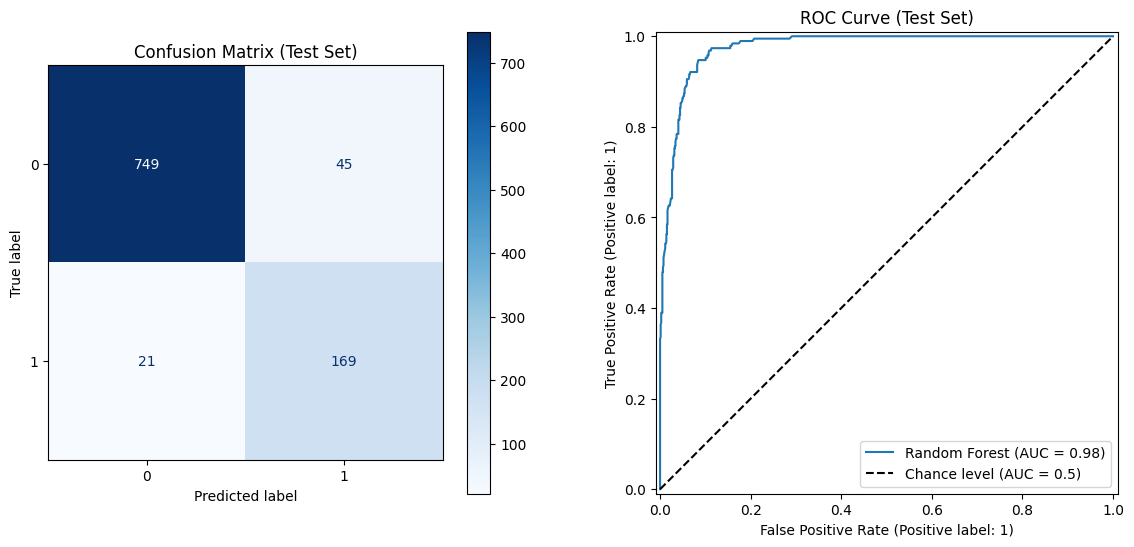

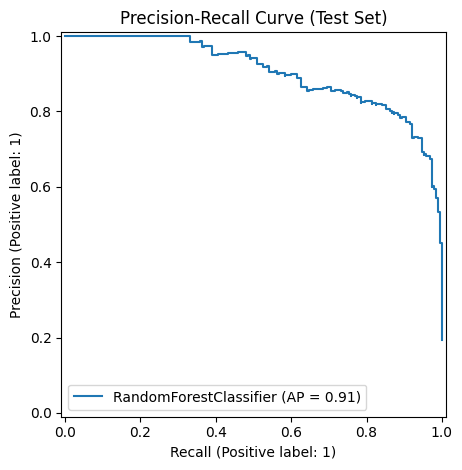

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_rf_selected_features, X_test, y_test, ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix (Test Set)')

# ROC Curve
RocCurveDisplay.from_estimator(best_rf_selected_features, X_test, y_test, ax=axes[1], name='Random Forest')
axes[1].plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
axes[1].set_title('ROC Curve (Test Set)')
axes[1].legend()

# Precision-Recall Curve (Optional, create another figure or subplot)
PrecisionRecallDisplay.from_estimator(best_rf_selected_features, X_test, y_test)
plt.title('Precision-Recall Curve (Test Set)')

plt.tight_layout()
plt.show()

## 9. Save the Final Model

In [15]:
model_save_path = '../../models/rf_model_selected_features_no_transformed.pkl'
joblib.dump(best_rf_selected_features, model_save_path)
print(f"Best Random Forest model (selected features with no transformation) saved to {model_save_path}")

Best Random Forest model (selected features with no transformation) saved to ../../models/rf_model_selected_features_no_transformed.pkl
